In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(directory['py'])
import techdata_to_tree, sys, ShockFunction
import abatement_EOP as abatement
os.chdir(directory['curr'])
def flatten_list(list_):
    return [item for sublist in list_ for item in sublist]

*Specify settings:*

In [2]:
name = 'A1_test'
f = {'tech': directory['data']+"/techdata_dors_2.xlsx",
     'other': directory['data']+"/Othdata_dors_2.xlsx"}
s = ['inputdisp','endofpipe','inputprices']
m = ['ID','EOP'] 
e = {'M': 'vars','M_sets': 'sets'} # dictionary used to load emissions data
other_trees = {'ID_Y': {'s': 'Y', 'read_data': {'Y': 'vars'}, 'Q2P': 'Q2P'}} # the key = tree name, s = sheet that specifies tree structure, read_data (if not None) specifies how to load data.

In [3]:
type_f = {'ID_EC': 'CES_norm',
          'ID_CU': 'MNL',
          'ID_TU': 'CET_norm',
          'ID_TX': 'CES',
          'ID_BU': 'linear_out',
          'ID_BX': 'CES',
          'EOP_CU': 'MNL',
          'EOP_TU': 'CET_norm',
          'EOP_TX': 'CES'}

*Set up nesting tree:*

In [4]:
%run ATree.ipynb

## 1: Initialize model

*Set up gams model from tree:*

In [7]:
gm = abatement.abate(nts=nts,tech=tech,work_folder=directory['work'],**{'data_folder':directory['gams'],'name': name})

*Add a couple of extra aliases, and update sets with elements:*

In [8]:
gm.add_aliases([('n','nnnn'),('n','nnnnn')])
gm.model.database.update_all_sets(clean_up=False)

*Initialise variables at leontief levels, and fill out with simple standard values in potentially missing domains:*

In [9]:
gm.initialize_variables_leontief()
gm.initialize_variables(**{'check_variables': True})

## 2: Baseline solution

*Set up model and solve:*

In [8]:
gm.write_and_run(name='baseline')
db0 = gm.model_instances['baseline'].out_db

*Print some?*

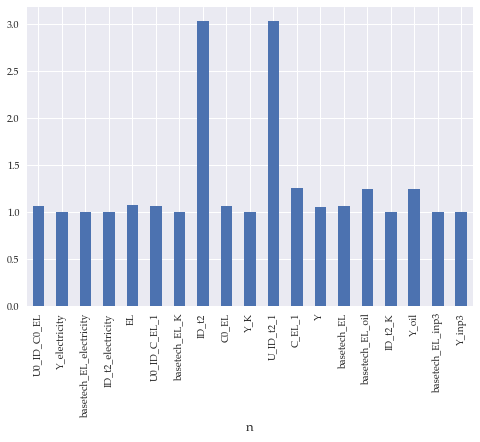

In [9]:
var = 'PwThat'
db0.get(var).plot.bar();

## A: Some debugging functions if there are problems with groups

*Debugging of initial states:*

In [10]:
debug = False
if debug is True:
    gm.initialize_variables(**{'check_variables': True})
    from IPython.display import Markdown
    # Test groupings:*
    var = gm.default_variables[1]
    display(Markdown(f"**{var}+' exogenous:'**"))
    display(gm.var_exo(var))
    display(Markdown(f"**{var}+' endogenous:'**"))
    display(gm.var_endo(var))

*Debugging of writing groups:*

In [10]:
group = gm.model.settings.name+'_'+'g_ID_alwaysendo'
debug_group = False
if debug_group is True:
    gm.initialize_variables(**{'check_variables':True})
    if group in gm.exo_groups:
        group_vals = gm.exo_groups[group] # corresponding group conditions 
    else:
        group_vals = gm.endo_groups[group]
    gm.model.groups[group] = group_vals # add to model.groups
    gm.model.settings.get_conf('g_exo').update([group]) # add to exogenous groups
    repo = None
    self = gm.model
    if repo is None:
        repo = self.settings.data_folder
    if not os.path.exists(repo):
        os.makedirs(repo)
    self.write_default_components()
    self.default_export(repo)

## B: Some details on added modules

### ID sums:

* Define the output share os[n,nn] as the share of output that technology $nn$ produces of energy-service type $n$. This should be defined as:

$$
\begin{align}
    \text{os[n,nn]} = \text{sum(nnn\$(e2u[n,nnn] and u2t[nnn,nn]), qD[nnn]) / qD[nn]}.
\end{align}
$$

* Define variable qSumX[n,nn] defined as the use of aggregate input type $nn\in (electricity,oil,inp3,K)$ used to produce energy service $n$. This is defined as:

$$\begin{align}
    \text{qSumX[n,nn]} = \text{sum([nnn,nnnn]\$(e2ai2i[n,nn,nnn] and e2t[n,nnnn] and i2t[nnn,nnnn]), qD[nnn] * os[n,nnnn])}
\end{align}$$
* Here e2ai2i identifies the relevant quantities $qD[i]$ that are tied to relevant aggregate type of input, $e2t[e,t]$ identifies the correct output-share $os[t,e]$, and $i2t[i,t]$ ensures that only the relevant $i,t$ combinations are summed over.


### ID emissions:

Emissions accounting with only the input displacing module:
* $M0[z]$ defines pre-emission abatement (equivalent to emissions without EOP module). This is defined over z (emission types).
* $phi[z,n]$ defines mission intensities over aggregate input types ($n\in ai[n]$).
Pre abatement emissions are then defined as:

$$\begin{align}
    M0[z] = sum(n$(ai[n]) phi[z,n] * qD[n]), 
\end{align}$$
* As long as the equation for the aggregate use of inputs in the sector (qD[n] for ai[n]) takes into account which modules are active, this equation stays the same across all states.

* $PwThat[n]\$(ID\_inp[n]):$ defines the effective prices on inputs, taking the price on emissions taxes and abatement into account:

$$\begin{align}
    PwThat[n] = PwT[n] + sum(z, phi[z,n] * pMhat[z]);
\end{align}$$

* As long as we establish an equation for pMhat[z] (corrected emission prices) that depends on the type of state the model is in, this equation stays the same across all states. However, with the EOP module activated, there should be an equivalent equation defined for ($EOP\_inp[n]$ and not $ID\_inp[n]$).

### ID Aggregates:

* If the state is ID the aggregate use of inputs ($qD[n]\$(ai[n])$) are defined from (we could let the namespace for 'ai' look up 'ID\_ai' instead of 'ai' when the EOP set is not activated?)

$$\begin{align}
    qD[n] = sum(nn\$(ID\_i2ai[nn,n]), qD[nn])
\end{align}$$

* Without the EOP module, a second equation simply states that $pMhat = pM$. 